<a href="https://colab.research.google.com/github/Meralbalik/Capstone-Project-2/blob/master/MNIST_GANs__first_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Dataset- GANs using Keras

In [0]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

#from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import mnist

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
# datasize
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


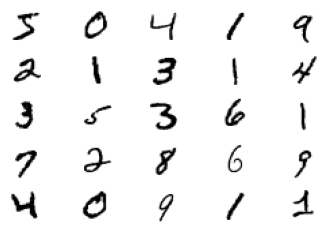

In [0]:
# plotting images from train set
for i in range(25):
  plt.subplot(5,5, 1+i)  # define the subplot
  plt.axis('off')   # turn off axis
  plt.imshow(x_train[i], cmap='gray_r')
plt.show()

### Defining the Discriminator

In [0]:
def discriminator():
    
    net = Sequential()
    input_shape = (28, 28, 1)
    dropout_prob = 0.4

    net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(512, 5, strides=1, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net

The full network structure is as follows:

In [0]:
net_discriminator = discriminator()
net_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 256)        

### Defining the Generator

In [0]:
def generator():
    
    net = Sequential()
    dropout_prob = 0.4
    
    net.add(Dense(7*7*256, input_dim=100))   # initially building 7*7 images
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((7,7,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(1, 5, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net

The full network structure is as follows:

In [0]:
net_generator = generator()
net_generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)      

### Creating the Models

We now defined the two separate networks but these still need to be combined in to two trainable models: one to train the discrmininator and one to train the generator. We first start with the most simple one which is the discriminator model.

In [0]:
optim_discriminator = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])

model_discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False

optim_adversarial = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])

model_adversarial.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


In [0]:
optim_adversarial = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False

model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])

model_adversarial.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


Reading the mnist data. We are only going to be using the train set.

In [0]:
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
x_train = x_train/255

## Training the GAN

With our models defined and the data loaded we can start training our GAN. The models are trained one after another, starting with the discriminator. The discriminator is trained on a data set of both fake and real images and tries to classify them correctly. The adversarial model is trained on noise vectors as explained above.

In [0]:
batch_size = 256
vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

for i in range(10001):
    
    # Select a random set of training images from the mnist dataset
    idx = np.random.randint(0, x_train.shape[0], size=batch_size)
    images_train = x_train[idx, :, :, :]
    # Generate a random noise vector
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    # Use the generator to create fake images from the noise vector
    images_fake = net_generator.predict(noise)
    
    # Create a dataset with fake and real images
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1]) # outcome consists of zeros for fake images and ones for real images
    y[batch_size:, :] = 0 

    # Train discriminator for one batch
    d_stats = model_discriminator.train_on_batch(x, y)
    
    # Train the generator
    # The input of the adversarial model is a list of noise vectors. The generator is 'good' if the discriminator classifies
    # all the generated images as real. Therefore, the desired output is a list of all ones.
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_stats = model_adversarial.train_on_batch(noise, y)
         
    # Optional, print losses instead of plotting with:
print("{}: [Dis. loss: {:.4f}, acc: {:.4f}] [Gen. loss: {:.4f}, acc: {:.4f}]".format(i, d_stats[0], d_stats[1], a_stats[0], a_stats[1]))

    

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
 if i % 50 == 0:
        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax1.plot(plot_iteration, loss_adv, label="loss adversarial")
        ax1.plot(plot_iteration, loss_dis, label="loss discriminator")
        ax1.set_ylim([0,5])
        ax1.legend()

        ax2.plot(plot_iteration, acc_adv, label="acc adversarial")
        ax2.plot(plot_iteration, acc_dis, label="acc discriminator")
        ax2.legend()

        plt.show()

if i % 500 == 0:
        # Visualize the performance of the generator by producing images from the test vector
        images = net_generator.predict(vis_noise)
        # Map back to original range
        #images = (images + 1 ) * 0.5
        plt.figure(figsize=(10,10))
        
        for im in range(images.shape[0]):
            plt.subplot(4, 4, im+1)
            image = images[im, :, :, :]
            image = np.reshape(image, [28, 28])

            plt.imshow(image, cmap='gray')
            plt.axis('off')
        
        plt.tight_layout()
        #plt.savefig(r'output/mnist-normal/{}.png'.format(i))
        plt.close('all')